# Quality of Life Analysis

In [220]:
# OS import
import os
import re
import datetime
import lxml
import requests
# Math
import pandas as pd
import numpy as np
# Data Visiualization
import matplotlib.pyplot as plt
import plotly.express as px
import kaleido
# APIs
from fredapi import Fred
import time

In [148]:
FRED_KEY = os.environ.get('FRED_KEY')
Fred_handler = Fred(api_key=FRED_KEY)
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

## Miscellaneous Code
<ul>
    <li>Dictionary for adding Deselect/Select All buttons</li>
    </ul>

In [149]:
select_deselect = dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              )

# Housing Analysis

In [150]:
res = Fred_handler.search(text="Home ownership")

## United States Homeownership

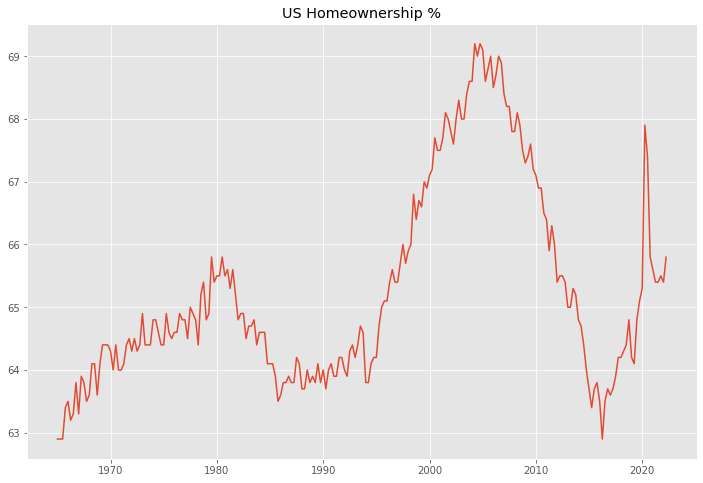

In [151]:
# df = Fred_handler.get_series('RHORUSQ156N')
plt.figure(figsize=(12,8))
plt.title("US Homeownership %")
plt.plot(df)
plt.show()

In [152]:
# Create pattern for State homeownership and find all series ids
pattern = re.compile('[A-Z]{2}HOWN')
homeownershipby_state = res[res.index.str.contains(pattern)]['id']

In [153]:
# Pull all accumulated series ids' from FRED. 
# Aggregate with python native dict type to avoid fragmentation errors
dict_series = {}
for series in homeownershipby_state:
    dict_series[series] = Fred_handler.get_series(series)

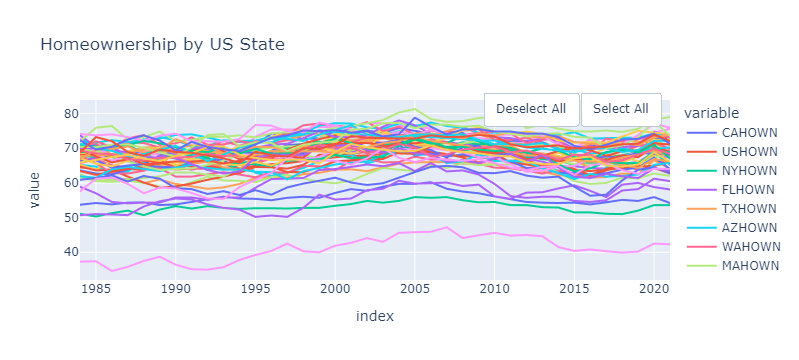

In [154]:
fig = px.line(pd.DataFrame.from_dict(dict_series), title="Homeownership by US State")
fig.update_layout(select_deselect)
fig.show()

## State County Evaluation
Fred_handler only returns up to 1000 results on a single call.

In [206]:
state_abbr = 'TX'
county_res = Fred_handler.search(f"Homeownership {state_abbr}")

In [221]:
_ = county_res[county_res.title.str.contains(state_abbr)]
counties = _['title'].str.strip('Homeownership Rate (5-year estimate) for')
counties = dict(counties)
dict_series = {}
for idx, k in enumerate(counties.keys()):
    if idx%100 == 0 and idx != 0:
        time.sleep(61)
    dict_series[counties[k]] = Fred_handler.get_series(k)

In [233]:
_ = pd.DataFrame(dict_series)
# fig = px.line(_, title=f"{state_abbr} Homeownership by County")
# fig.update_layout(select_deselect)
# fig.show()

In [269]:
feat_dict = {}
copy = _.T.describe().iloc[1:, :]
for i in copy.index:
    feat_dict[i] = copy[i]
feat_dict

KeyError: 'mean'

In [267]:
_.T.agg(['mean', 'std'])

,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
mean,73.185621,73.525607,73.224992,72.743910,72.204462,71.933180,71.663617,71.433538,71.764879,71.965035,72.225544,72.885128
std,7.238739,7.099894,7.699424,7.500492,8.320678,8.449388,8.247833,7.880382,8.647573,8.061559,8.576005,8.800607


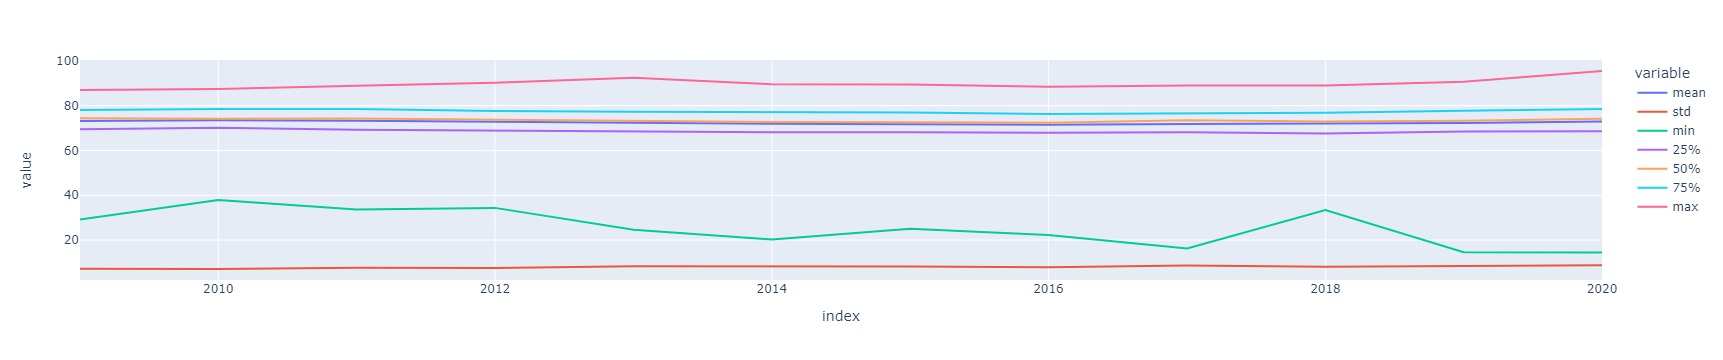

In [257]:
px.line(feat_dict.T)

## County Feature Creation
<h4>There are over 3,200 counties in the United States.</h4>
Inspecting each individual county would be tedious, if not impossible. Developing ways to highlight trends and seperate or view outliers can be crucial to timely analysis. 
<h5>Some states have hundreds of counties</h5>
Graphing hundreds of counties, especially on an interactive graph will be extremely intensive and result in performance drops, fragmentation warnings and possibly corruption errors. This makes using aggregated features a necessity.
<ul>
    <li>AVG/Mean</li>
    <li>Median</li>
    <li>Q1, IQR, Q3, STD</li>
    <li>Lowest/Highest</li>
</ul>

In [234]:
series_list = []
for i in range(0, len(_.index)):
    series_list.append(_.iloc[i, :].agg('mean', 'std', 'min', 'max'))
_['mean'] = series_list
_.iloc[-2:, -5:]

,"San Saba County, TX","Jeff Davis County, TX","San Augustine County, TX","Tom Green County, TX",mean
2019-01-01,68.365421,80.339917,80.116959,66.387614,72.225544
2020-01-01,68.557476,77.655678,73.585141,67.886624,72.885128


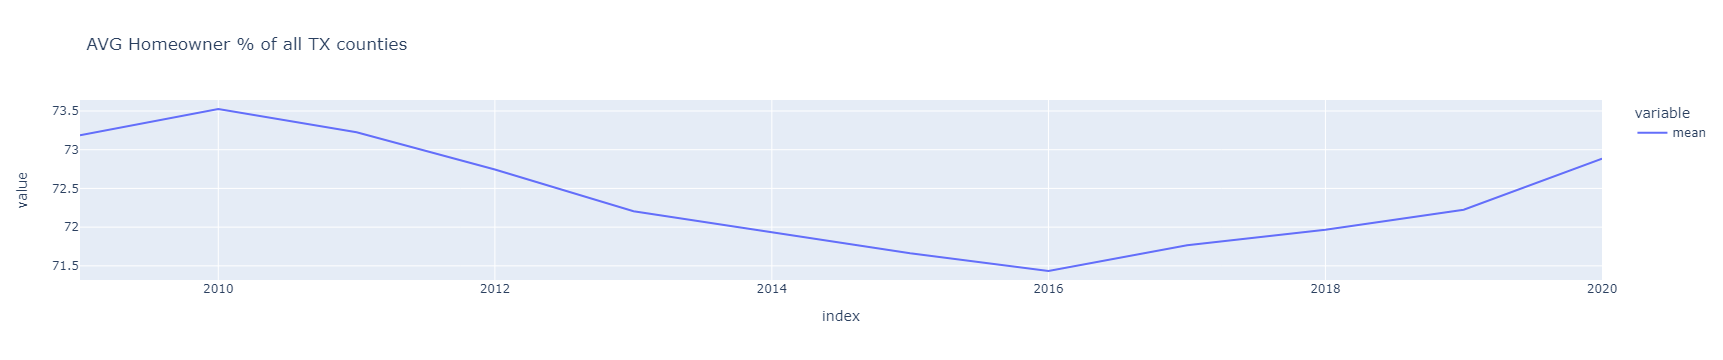

In [235]:
px.line(_['mean'], title="AVG Homeowner % of all TX counties")